# Prognosis Benchmarking Example

This notebook provides a comprehensive workflow for benchmarking machine learning models in the context of Prognostics and Health Management (PHM) using multiple datasets with the package `phmd`. The focus is on Remaining Useful Life (RUL) prediction tasks. 

The following functions are utility functions used in the benchmarking loop:

In [1]:
from phmd import datasets
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def window_split(X, unit_id, signal_cols, target_col, subsignal_length=1000, signal_max_length=20000):
    """
    Splits time-series data into fixed-length windows for training machine learning models.
    
    This function processes time-series data, splitting it into smaller, fixed-length segments (windows).
    It ensures that each segment corresponds to a specific unit identified by the `unit_id` column
    and aligns the target variable for each segment to the last value in the window. 
    
    Parameters:
    -----------
    X : pandas.DataFrame
        The input dataset containing the time-series data.
        Must include columns specified by `unit_id`, `signal_cols`, and `target_col`.
    
    unit_id : str
        The name of the column in `X` used to identify individual units in the dataset.
    
    signal_cols : list of str
        A list of column names in `X` representing the signal data (features) for each unit.
    
    target_col : str
        The name of the column in `X` representing the target variable to predict.
    
    subsignal_length : int, optional, default=1000
        The length of each window (number of time-steps) to extract from the signal.
    
    signal_max_length : int, optional, default=20000
        The maximum number of time-steps to consider per unit.
        Excess data is truncated from the beginning to fit within this limit.
    
    Returns:
    --------
    X : numpy.ndarray
        A 3D array of shape `(num_windows, subsignal_length, num_features)`, where:
            - `num_windows` is the total number of extracted windows across all units.
            - `subsignal_length` is the fixed length of each window.
            - `num_features` is the number of signal features.
    
    Y : numpy.ndarray
        A 1D array of shape `(num_windows,)` containing the target variable values
        for each window, corresponding to the last time-step in the window.
    
    Example:
    --------
    >>> import pandas as pd
    >>> df = pd.DataFrame({
    ...     'unit_id': [1, 1, 1, 2, 2, 2],
    ...     'signal1': [0.1, 0.2, 0.3, 0.5, 0.6, 0.7],
    ...     'signal2': [0.4, 0.5, 0.6, 0.8, 0.9, 1.0],
    ...     'target': [10, 20, 30, 40, 50, 60]
    ... })
    >>> X, Y = window_split(df, 'unit_id', ['signal1', 'signal2'], 'target', subsignal_length=2, signal_max_length=4)
    >>> print(X.shape)
    (2, 2, 2)
    >>> print(Y)
    [20. 50.]
    """
        
    units_array = X[unit_id].values
    signal_array = X[signal_cols].values
    targets = X[target_col].values
    N = signal_max_length // subsignal_length

    num_units = X[unit_id].drop_duplicates().shape[0]
    unique_units = X[unit_id].drop_duplicates().values
    X = np.zeros((N * num_units, subsignal_length, len(signal_cols)))
    Y = np.zeros((N * num_units,))
    NN = 0
    for i, unit in enumerate(unique_units):
        mask = np.all(units_array == unit, axis=1)
        signal = signal_array[mask]
        sml = (signal.shape[0] // subsignal_length) * subsignal_length
        n = min(sml // subsignal_length, N)
        sml = subsignal_length * n
        signal = signal[-sml:]
        signal = signal.reshape((n, subsignal_length, len(signal_cols)))
        signal_target = targets[-sml:]
        signal_target = signal_target.reshape((n, subsignal_length))
        X[NN:NN + n] = signal
        Y[NN:NN + n] = signal_target[:, -1]
        NN += n

    X = X[:NN]

    return X, Y


def create_conv_1d_network(input_shape):
    """
    This function defines a 1D CNN architecture suitable for RUL tasks.
    The model consists of multiple convolutional layers, followed by 
    max-pooling layers for feature extraction,  and dense layers for prediction.
    
    Parameters:
    -----------
    input_shape : tuple
        The shape of the input data (timesteps, features). This defines the dimensions 
        of the input layer.
    
    Returns:
    --------
    tf.keras.Model
        A compiled Keras Model with the defined architecture.
    """
    # Define the input layer
    input = tf.keras.layers.Input(input_shape)

    # Initialize the input for stacking
    x = input

    # Add 4 blocks of convolutional and pooling layers
    for i in range(4):
        # Each block contains three Conv1D layers with 64 filters and a kernel size of 3
        x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
        # Add a MaxPooling1D layer to downsample the feature maps
        x = tf.keras.layers.MaxPooling1D(2)(x)

    # Flatten the feature maps to prepare for dense layers
    x = tf.keras.layers.Flatten()(x)
    # Fully connected layers for prediction
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    # Output layer: single neuron with ReLU activation (suitable for regression tasks)
    x = tf.keras.layers.Dense(1, activation='relu')(x)

    # Create and return the Keras Model
    return tf.keras.models.Model(inputs=input, outputs=x)



def train(train_data, epochs, es=True, validation_data=None):
    """
    This function trains a 1D convolutional neural network using the provided training data and 
    optional validation data. It employs early stopping during training and performs an initial 
    sanity check to ensure that the training loss evolves correctly before proceeding with full training.
    
    Parameters:
    -----------
    train_data : tuple
        A tuple `(X_train, Y_train)` containing the training data:
            - `X_train` : numpy.ndarray
                Input features for training (shape: `(num_samples, timesteps, features)`).
            - `Y_train` : numpy.ndarray
                Target values for training (shape: `(num_samples,)`).
    
    epochs : int
        Number of epochs for the final training phase.
    
    es : bool, optional, default=True
        If `True`, early stopping is applied during training. Early stopping monitors the validation loss 
        and stops training if the loss does not improve for 8 consecutive epochs.
    
    validation_data : tuple, optional, default=None
        A tuple `(X_val, Y_val)` containing validation data:
            - `X_val` : numpy.ndarray
                Input features for validation.
            - `Y_val` : numpy.ndarray
                Target values for validation.
    
    Returns:
    --------
    results : History
        A Keras History object containing details about the training process, including loss and metric values.
    
    model : tf.keras.Model
        The trained model.
    
    
    Example:
    --------
    >>> train_data = (X_train, Y_train)
    >>> validation_data = (X_val, Y_val)
    >>> results, model = train(train_data, epochs=50, validation_data=validation_data)
    """    
    # Unpack training data
    X_train, Y_train = train_data

    # Configure callbacks for early stopping if enabled
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)] if es else []

    valid_train = False
    while not valid_train:
        # Create and compile the model
        model = create_conv_1d_network(X_train.shape[1:])
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['mae'], loss='mse')

        # Perform an initial short training session (3 epochs) to validate training behavior
        results = model.fit(X_train, Y_train,
                            epochs=3,
                            batch_size=128,
                            verbose=1,
                            validation_data=validation_data,
                            callbacks=callbacks)

        # Check if the loss has sufficient variance to ensure proper learning
        valid_train = np.std(results.history['loss']) > 1e-3

    # Perform full training with the specified number of epochs
    results = model.fit(X_train, Y_train,
                        epochs=epochs,
                        batch_size=128,
                        verbose=1,
                        validation_data=validation_data,
                        callbacks=callbacks)

    return results, model


2024-12-10 09:52:43.990407: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Benchmarking Loop

For this example have been selecte three small dataset: `CALCE_CS2`, `ARAMIS20`, and `PHME20`.

The `datasets.Dataset` class is used to load and manage datasets. It supports preprocessing, normalization, and splitting for cross-validation. 

This example implements a 3-fold cross-validation setup and MinMaxScaler to normalize input features. Defines a 1D Convolutional Neural Network (Conv1D) using TensorFlow/Keras. The architecture includes multiple convolutional layers followed by dense layers, optimized for time-series data.

After cross-validation, a final model is trained on the combined training and validation data for each dataset.

In [2]:
# List of datasets to process
DATASETS = ['PHME20', 'ARAMIS20', 'CALCE_CS2']

# Dictionary to store predictions and results for each dataset
# predictions = {}

# Loop through each dataset
for dataset in DATASETS:
    # Load the dataset using the Dataset class
    ds = datasets.Dataset(dataset)
    
    # Access the Remaining Useful Life (RUL) task associated with the dataset
    task = ds['rul']
    
    # Configure the task settings
    task.folds = 3  # Number of cross-validation folds
    task.normalize_output = True  # Normalize the output (target values)
    task.preprocess = MinMaxScaler()  # Apply MinMaxScaler as a preprocessing step
    
    # Determine the subsequence length (TS) for windowing the data
    TS = min(1024, ds['rul'].meta['min_ts_len'] // 20)
    
    # List to store the number of epochs for early stopping across folds
    ea_epochs = []
    
    # Get the unit identifier for grouping data
    unit_id = ds['rul'].meta['identifier']
    
    # Define the number of epochs for training
    EPOCHS = 100
    
    # Cross-validation loop
    for i in range(task.folds):
        # Retrieve the data for the current fold (training, validation, test sets)
        data = task[i]
        X_train, X_val, X_test = data['train'], data['val'], data['test']
        
        # Calculate the minimum signal length across training, validation, and test sets
        signal_sizes = [
            X_train.groupby(unit_id).size().min(),
            X_val.groupby(unit_id).size().min(),
            X_test.groupby(unit_id).size().min()
        ]
        signal_max_length = min(np.min(signal_sizes), 20000000)
        
        # Prepare the data for training and validation using windowing
        X_train, Y_train = window_split(X_train, unit_id, ds['rul'].meta['features'], 'rul', TS, signal_max_length)
        X_val, Y_val = window_split(X_val, unit_id, ds['rul'].meta['features'], 'rul', TS, signal_max_length)
        
        # Train the model using the training data and validate on validation data
        results, model = train((X_train, Y_train), EPOCHS, es=True, validation_data=(X_val, Y_val))
        
        # Record the number of epochs run before early stopping
        ea_epochs.append(len(results.history['loss']))
    
    # Train the final model using all training and validation data
    train_data = np.concatenate((X_train, X_val)), np.concatenate((Y_train, Y_val))
    results, model = train(train_data, int(np.mean(ea_epochs)), es=False, validation_data=None)
    
    # Evaluate the model on one specific unit of the test set
    unit = np.unique(X_test[ds['rul'].meta['identifier']].values)[0]
    unit_mask = np.all(X_test[ds['rul'].meta['identifier']] == unit, axis=1)
    aux = X_test[unit_mask]
    X_aux, Y_aux = window_split(aux, unit_id, ds['rul'].meta['features'], 'rul', TS, signal_max_length)
    Y_pred = model.predict(X_aux)
    
    # Evaluate the model on the entire test set
    X_test, Y_test = window_split(X_test, unit_id, ds['rul'].meta['features'], 'rul', TS, signal_max_length)
    results = model.evaluate(X_test, Y_test)
    
    # Store the predictions and results for the current dataset
    predictions[dataset] = [Y_aux, Y_pred, results]


Remember to cite the original publisher dataset:
	@InProceedings{PHME20-GTU,
	    author = {Kürşat İnce and Engin Sirkeci and Yakup Genç},
	    title = {Remaining Useful Life Prediction for Experimental Filtration System: A Data Challenge},
	    booktitle = {Proceedings of the European Conference of the PHM Society 2020},
	    month = July,
	    year = 2020,
	    publisher = {PHM Society},
	    editor = {Anibal Bregon & Kamal Medjaher},
	    note = {Available at https://phmpapers.org/index.php/phme/article/view/1317}
	}
You can download the dataset manually from:  https://github.com/zakkum42/phme20-public

** If you find this tool useful, please cite our SoftwareX paper.



/home/dasolma/.phmd/datasets/PHME20.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 997k/997k [00:00<00:00, 3.14MB/s]


Extracting files PHME20...


Reading : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 136.73it/s]
INFO:root:Read in 3.9960100650787354 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: Flow_Rate(ml/m),Upstream_Pressure(psi),Downstream_Pressure(psi),Particle Size (micron),Solid Ratio(%),rul,unit
INFO:root:Train shape: (37460, 7)
INFO:root:Val shape: (16534, 7)
INFO:root:Test shape: (21800, 7)
2024-12-10 09:54:53.519840: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-12-10 09:54:53.521126: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-12-10 09:54:53.563332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapabi

Epoch 1/3


2024-12-10 09:54:55.284777: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-12-10 09:54:55.430462: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


3/3 [==============================] - 3s 334ms/step - loss: 0.3001 - mae: 0.4671 - val_loss: 0.2158 - val_mae: 0.3950
Epoch 2/3
3/3 [==============================] - 0s 33ms/step - loss: 0.2884 - mae: 0.4573 - val_loss: 0.2060 - val_mae: 0.3836
Epoch 3/3
3/3 [==============================] - 0s 34ms/step - loss: 0.2869 - mae: 0.4581 - val_loss: 0.1920 - val_mae: 0.3669
Epoch 1/100
3/3 [==============================] - 0s 51ms/step - loss: 0.2556 - mae: 0.4232 - val_loss: 0.1733 - val_mae: 0.3450
Epoch 2/100
3/3 [==============================] - 0s 31ms/step - loss: 0.2310 - mae: 0.3992 - val_loss: 0.1484 - val_mae: 0.3156
Epoch 3/100
3/3 [==============================] - 0s 32ms/step - loss: 0.1997 - mae: 0.3677 - val_loss: 0.1170 - val_mae: 0.2777
Epoch 4/100
3/3 [==============================] - 0s 32ms/step - loss: 0.1587 - mae: 0.3257 - val_loss: 0.0830 - val_mae: 0.2370
Epoch 5/100
3/3 [==============================] - 0s 32ms/step - loss: 0.1160 - mae: 0.2825 - val_loss: 

Reading : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 156.80it/s]
INFO:root:Read in 0.22841119766235352 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: Flow_Rate(ml/m),Upstream_Pressure(psi),Downstream_Pressure(psi),Particle Size (micron),Solid Ratio(%),rul,unit
INFO:root:Train shape: (34744, 7)
INFO:root:Val shape: (19250, 7)
INFO:root:Test shape: (21800, 7)


Epoch 1/3
3/3 [==============================] - 1s 140ms/step - loss: 0.2255 - mae: 0.4046 - val_loss: 0.2979 - val_mae: 0.4656
Epoch 2/3
3/3 [==============================] - 0s 33ms/step - loss: 0.2216 - mae: 0.4023 - val_loss: 0.2920 - val_mae: 0.4599
Epoch 3/3
3/3 [==============================] - 0s 31ms/step - loss: 0.2145 - mae: 0.3920 - val_loss: 0.2836 - val_mae: 0.4515
Epoch 1/100
3/3 [==============================] - 0s 54ms/step - loss: 0.2052 - mae: 0.3828 - val_loss: 0.2721 - val_mae: 0.4397
Epoch 2/100
3/3 [==============================] - 0s 37ms/step - loss: 0.1940 - mae: 0.3693 - val_loss: 0.2569 - val_mae: 0.4242
Epoch 3/100
3/3 [==============================] - 0s 30ms/step - loss: 0.1789 - mae: 0.3514 - val_loss: 0.2359 - val_mae: 0.4034
Epoch 4/100
3/3 [==============================] - 0s 30ms/step - loss: 0.1577 - mae: 0.3273 - val_loss: 0.2079 - val_mae: 0.3754
Epoch 5/100
3/3 [==============================] - 0s 31ms/step - loss: 0.1324 - mae: 0.2982 - 

Reading : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 161.66it/s]
INFO:root:Read in 0.21459627151489258 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: Flow_Rate(ml/m),Upstream_Pressure(psi),Downstream_Pressure(psi),Particle Size (micron),Solid Ratio(%),rul,unit
INFO:root:Train shape: (35784, 7)
INFO:root:Val shape: (18210, 7)
INFO:root:Test shape: (21800, 7)


Epoch 1/3
3/3 [==============================] - 1s 137ms/step - loss: 0.2208 - mae: 0.4019 - val_loss: 0.2531 - val_mae: 0.4301
Epoch 2/3
3/3 [==============================] - 0s 32ms/step - loss: 0.2189 - mae: 0.3985 - val_loss: 0.2531 - val_mae: 0.4301
Epoch 3/3
3/3 [==============================] - 0s 33ms/step - loss: 0.2203 - mae: 0.3971 - val_loss: 0.2531 - val_mae: 0.4301
Epoch 1/3
3/3 [==============================] - 1s 156ms/step - loss: 0.2241 - mae: 0.4058 - val_loss: 0.2531 - val_mae: 0.4301
Epoch 2/3
3/3 [==============================] - 0s 31ms/step - loss: 0.2247 - mae: 0.4044 - val_loss: 0.2531 - val_mae: 0.4301
Epoch 3/3
3/3 [==============================] - 0s 32ms/step - loss: 0.2267 - mae: 0.4072 - val_loss: 0.2531 - val_mae: 0.4301
Epoch 1/3
3/3 [==============================] - 1s 143ms/step - loss: 0.2240 - mae: 0.4024 - val_loss: 0.2411 - val_mae: 0.4173
Epoch 2/3
3/3 [==============================] - 0s 29ms/step - loss: 0.2172 - mae: 0.3979 - val_loss

/home/dasolma/.phmd/datasets/ARAMIS20.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73.0M/73.0M [00:27<00:00, 2.77MB/s]


Extracting files ARAMIS20...


Reading : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.10s/it]
INFO:root:Read in 35.30456233024597 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,component,unit,rul
INFO:root:Train shape: (187830, 13)
INFO:root:Val shape: (101832, 13)
INFO:root:Test shape: (119535, 13)


Epoch 1/3
30/30 [==============================] - 1s 20ms/step - loss: 0.2169 - mae: 0.3836 - val_loss: 0.2271 - val_mae: 0.3991
Epoch 2/3
30/30 [==============================] - 0s 11ms/step - loss: 0.2140 - mae: 0.3793 - val_loss: 0.2271 - val_mae: 0.3991
Epoch 3/3
30/30 [==============================] - 0s 12ms/step - loss: 0.2125 - mae: 0.3779 - val_loss: 0.2271 - val_mae: 0.3991
Epoch 1/3
30/30 [==============================] - 1s 19ms/step - loss: 0.1518 - mae: 0.3129 - val_loss: 0.0588 - val_mae: 0.2131
Epoch 2/3
30/30 [==============================] - 0s 12ms/step - loss: 0.0564 - mae: 0.2065 - val_loss: 0.0355 - val_mae: 0.1595
Epoch 3/3
30/30 [==============================] - 0s 13ms/step - loss: 0.0276 - mae: 0.1357 - val_loss: 0.0159 - val_mae: 0.0949
Epoch 1/100
30/30 [==============================] - 0s 13ms/step - loss: 0.0102 - mae: 0.0728 - val_loss: 0.0116 - val_mae: 0.0761
Epoch 2/100
30/30 [==============================] - 0s 12ms/step - loss: 0.0065 - mae: 

Reading : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.03s/it]
INFO:root:Read in 4.205318927764893 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,component,unit,rul
INFO:root:Train shape: (186749, 13)
INFO:root:Val shape: (102913, 13)
INFO:root:Test shape: (119535, 13)


Epoch 1/3
30/30 [==============================] - 2s 19ms/step - loss: 0.1695 - mae: 0.3298 - val_loss: 0.0581 - val_mae: 0.2111
Epoch 2/3
30/30 [==============================] - 0s 12ms/step - loss: 0.0523 - mae: 0.1996 - val_loss: 0.0286 - val_mae: 0.1448
Epoch 3/3
30/30 [==============================] - 0s 12ms/step - loss: 0.0249 - mae: 0.1300 - val_loss: 0.0183 - val_mae: 0.1061
Epoch 1/100
30/30 [==============================] - 0s 13ms/step - loss: 0.0170 - mae: 0.1005 - val_loss: 0.0145 - val_mae: 0.0899
Epoch 2/100
30/30 [==============================] - 0s 12ms/step - loss: 0.0126 - mae: 0.0809 - val_loss: 0.0100 - val_mae: 0.0669
Epoch 3/100
30/30 [==============================] - 0s 12ms/step - loss: 0.0093 - mae: 0.0632 - val_loss: 0.0087 - val_mae: 0.0665
Epoch 4/100
30/30 [==============================] - 0s 12ms/step - loss: 0.0090 - mae: 0.0620 - val_loss: 0.0066 - val_mae: 0.0529
Epoch 5/100
30/30 [==============================] - 0s 12ms/step - loss: 0.0070 -

Reading : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.11s/it]
INFO:root:Read in 4.285794973373413 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,component,unit,rul
INFO:root:Train shape: (204745, 13)
INFO:root:Val shape: (84917, 13)
INFO:root:Test shape: (119535, 13)


Epoch 1/3
33/33 [==============================] - 1s 20ms/step - loss: 0.1977 - mae: 0.3663 - val_loss: 0.0879 - val_mae: 0.2487
Epoch 2/3
33/33 [==============================] - 0s 11ms/step - loss: 0.0725 - mae: 0.2297 - val_loss: 0.0483 - val_mae: 0.1914
Epoch 3/3
33/33 [==============================] - 0s 12ms/step - loss: 0.0384 - mae: 0.1679 - val_loss: 0.0174 - val_mae: 0.1084
Epoch 1/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0137 - mae: 0.0905 - val_loss: 0.0107 - val_mae: 0.0809
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0106 - mae: 0.0762 - val_loss: 0.0080 - val_mae: 0.0642
Epoch 3/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0090 - mae: 0.0674 - val_loss: 0.0064 - val_mae: 0.0548
Epoch 4/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0076 - mae: 0.0587 - val_loss: 0.0064 - val_mae: 0.0586
Epoch 5/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0071 -

/home/dasolma/.phmd/datasets/CALCE_CS2.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98.7M/98.7M [00:31<00:00, 3.24MB/s]


Extracting files CALCE_CS2...


Reading data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:11<00:00, 12.84it/s]
INFO:root:Read in 51.18823313713074 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),AC_Impedance(Ohm),ACI_Phase_Angle(Deg),unit,soc,rul
INFO:root:Train shape: (840627, 13)
INFO:root:Val shape: (587177, 13)
INFO:root:Test shape: (255020, 13)


Epoch 1/3
6/6 [==============================] - 1s 102ms/step - loss: 0.3006 - mae: 0.4896 - val_loss: 0.2713 - val_mae: 0.4583
Epoch 2/3
6/6 [==============================] - 0s 39ms/step - loss: 0.2155 - mae: 0.3965 - val_loss: 0.1044 - val_mae: 0.2671
Epoch 3/3
6/6 [==============================] - 0s 41ms/step - loss: 0.0694 - mae: 0.2194 - val_loss: 0.0757 - val_mae: 0.2299
Epoch 1/100
6/6 [==============================] - 0s 50ms/step - loss: 0.0644 - mae: 0.2125 - val_loss: 0.0514 - val_mae: 0.1937
Epoch 2/100
6/6 [==============================] - 0s 40ms/step - loss: 0.0552 - mae: 0.1985 - val_loss: 0.0647 - val_mae: 0.2122
Epoch 3/100
6/6 [==============================] - 0s 39ms/step - loss: 0.0494 - mae: 0.1878 - val_loss: 0.0425 - val_mae: 0.1785
Epoch 4/100
6/6 [==============================] - 0s 40ms/step - loss: 0.0427 - mae: 0.1779 - val_loss: 0.0387 - val_mae: 0.1712
Epoch 5/100
6/6 [==============================] - 0s 40ms/step - loss: 0.0373 - mae: 0.1681 - 

Reading data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:11<00:00, 12.81it/s]
INFO:root:Read in 14.32518744468689 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),AC_Impedance(Ohm),ACI_Phase_Angle(Deg),unit,soc,rul
INFO:root:Train shape: (874360, 13)
INFO:root:Val shape: (553444, 13)
INFO:root:Test shape: (255020, 13)


Epoch 1/3
6/6 [==============================] - 1s 138ms/step - loss: 0.3097 - mae: 0.4963 - val_loss: 0.3268 - val_mae: 0.4979
Epoch 2/3
6/6 [==============================] - 0s 40ms/step - loss: 0.2368 - mae: 0.4208 - val_loss: 0.1665 - val_mae: 0.3412
Epoch 3/3
6/6 [==============================] - 0s 40ms/step - loss: 0.0930 - mae: 0.2536 - val_loss: 0.0898 - val_mae: 0.2490
Epoch 1/100
6/6 [==============================] - 0s 48ms/step - loss: 0.0821 - mae: 0.2349 - val_loss: 0.0757 - val_mae: 0.2365
Epoch 2/100
6/6 [==============================] - 0s 39ms/step - loss: 0.0624 - mae: 0.2127 - val_loss: 0.0986 - val_mae: 0.2651
Epoch 3/100
6/6 [==============================] - 0s 40ms/step - loss: 0.0616 - mae: 0.2112 - val_loss: 0.0771 - val_mae: 0.2374
Epoch 4/100
6/6 [==============================] - 0s 40ms/step - loss: 0.0538 - mae: 0.1987 - val_loss: 0.0673 - val_mae: 0.2239
Epoch 5/100
6/6 [==============================] - 0s 40ms/step - loss: 0.0526 - mae: 0.1963 - 

Reading data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:12<00:00, 12.54it/s]
INFO:root:Read in 14.66904067993164 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),AC_Impedance(Ohm),ACI_Phase_Angle(Deg),unit,soc,rul
INFO:root:Train shape: (1140621, 13)
INFO:root:Val shape: (287183, 13)
INFO:root:Test shape: (255020, 13)


Epoch 1/3
8/8 [==============================] - 1s 77ms/step - loss: 0.3632 - mae: 0.5434 - val_loss: 0.3204 - val_mae: 0.5061
Epoch 2/3
8/8 [==============================] - 0s 32ms/step - loss: 0.3611 - mae: 0.5425 - val_loss: 0.3204 - val_mae: 0.5061
Epoch 3/3
8/8 [==============================] - 0s 31ms/step - loss: 0.3556 - mae: 0.5366 - val_loss: 0.3204 - val_mae: 0.5061
Epoch 1/3
8/8 [==============================] - 1s 65ms/step - loss: 0.3454 - mae: 0.5275 - val_loss: 0.2698 - val_mae: 0.4562
Epoch 2/3
8/8 [==============================] - 0s 32ms/step - loss: 0.2660 - mae: 0.4503 - val_loss: 0.1109 - val_mae: 0.2781
Epoch 3/3
8/8 [==============================] - 0s 33ms/step - loss: 0.0976 - mae: 0.2628 - val_loss: 0.0917 - val_mae: 0.2460
Epoch 1/100
8/8 [==============================] - 0s 40ms/step - loss: 0.0662 - mae: 0.2162 - val_loss: 0.0558 - val_mae: 0.2030
Epoch 2/100
8/8 [==============================] - 0s 33ms/step - loss: 0.0576 - mae: 0.2054 - val_los

## Visualization

Generates side-by-side plots for each dataset, showing true RUL values and model predictions. Each plot also displays the MAE, obtained in the full test set, in the bottom-left corner for quick reference.

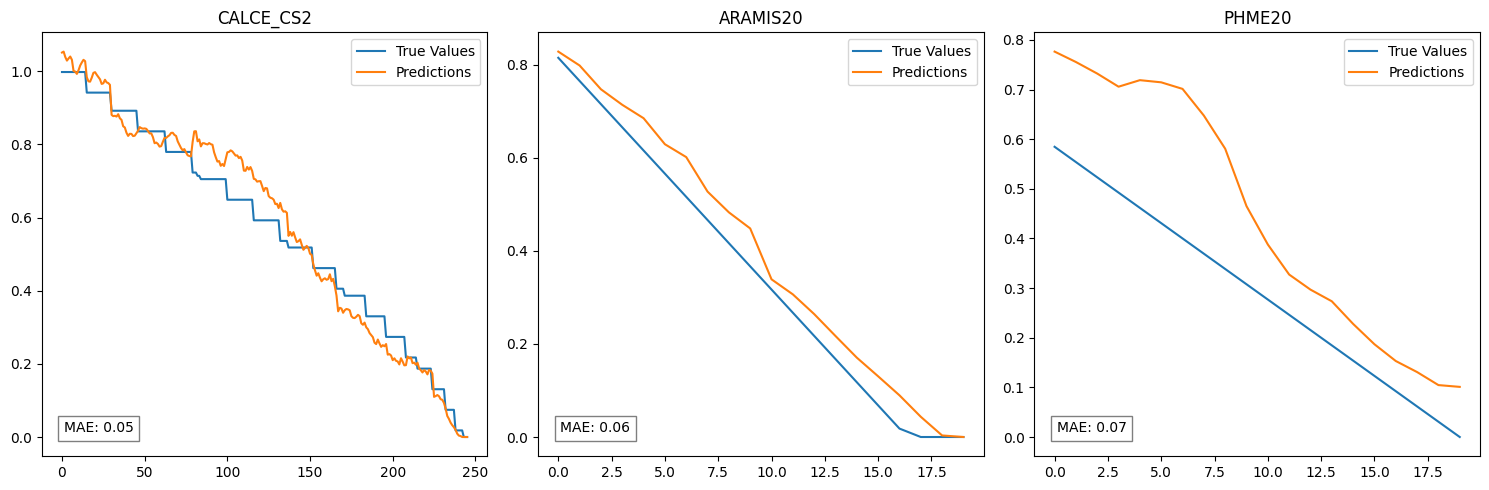

In [5]:
DATASETS = ['CALCE_CS2', 'ARAMIS20', 'PHME20']

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over datasets and axes
for ax, dataset in zip(axes, DATASETS):
    # Extract true values, predictions, and results
    Y_aux, Y_pred, results = predictions[dataset]
    
    # Calculate Mean Absolute Error (MAE)
    mae = results[1]
    
    # Plot true values and predictions
    ax.plot(Y_aux, label="True Values")
    ax.plot(Y_pred, label="Predictions")
    
    # Set the title and legend
    ax.set_title(dataset)
    ax.legend()
    
    # Add MAE text in the bottom-left corner
    ax.text(0.05, 0.05, f"MAE: {mae:.2f}", transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('prog_example.svg')
plt.show()
